In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, wave, pylab, itertools
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix

# setando os caminhos
INPUT_DIR = 'audios/'
OUTPUT_DIR = 'working/'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

5_nicolas_9.wav
3_yweweler_14.wav
1_lucas_5.wav
2_george_44.wav
4_yweweler_38.wav
3_yweweler_28.wav
4_yweweler_10.wav
3_george_1.wav
1_nicolas_15.wav
1_jackson_42.wav


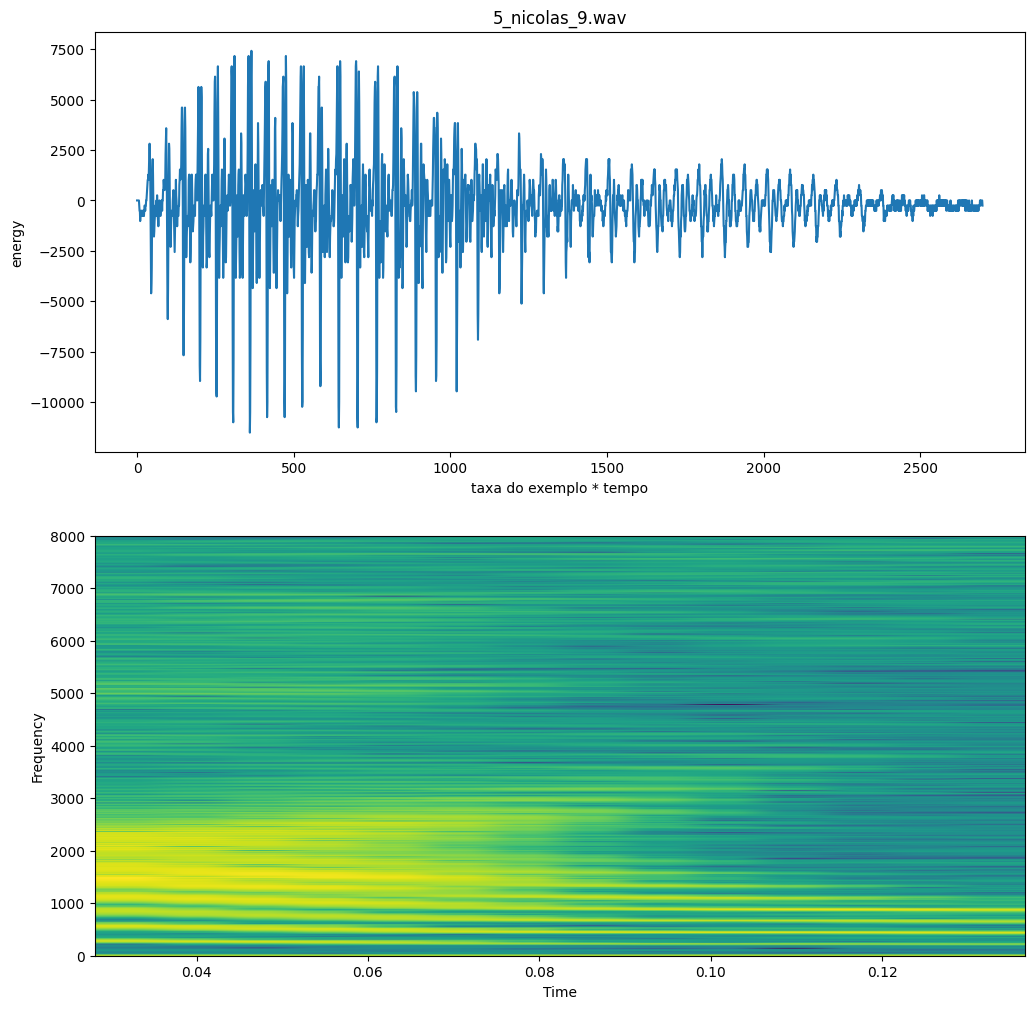

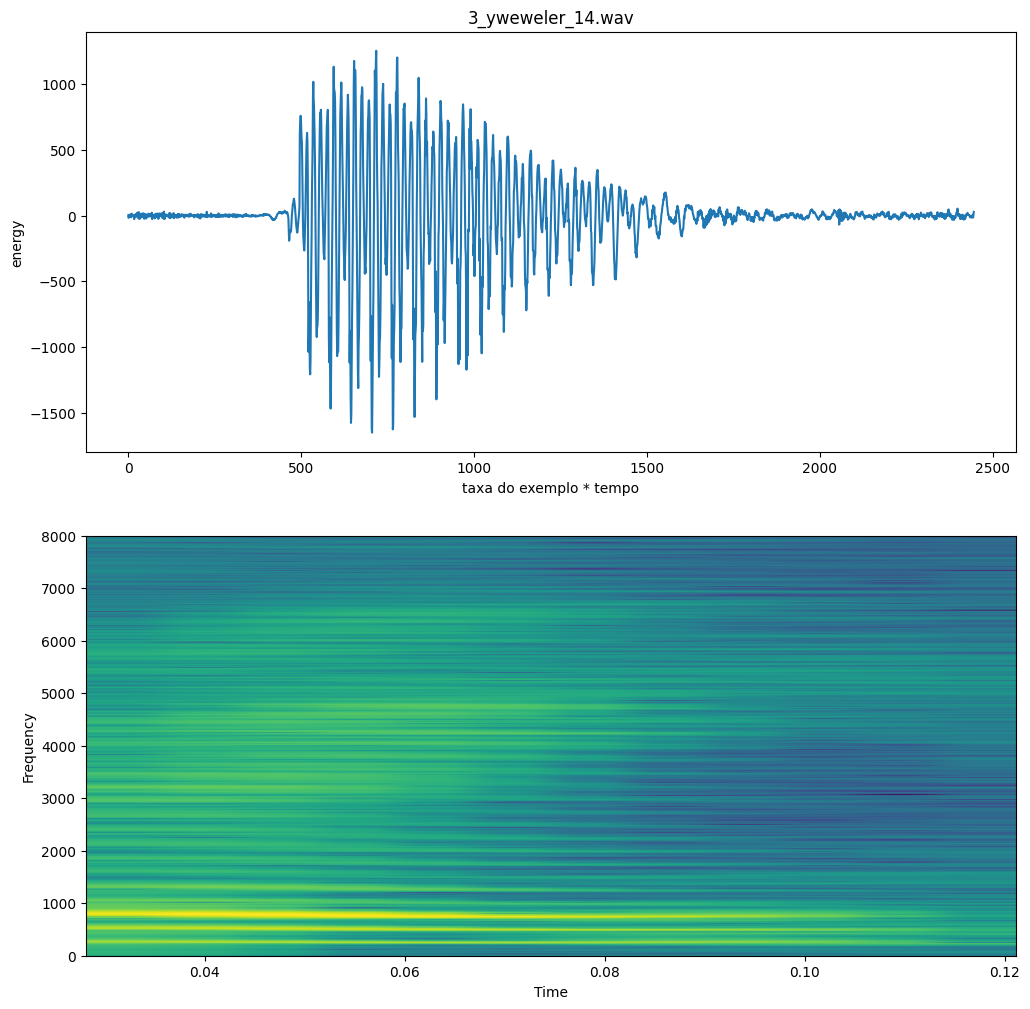

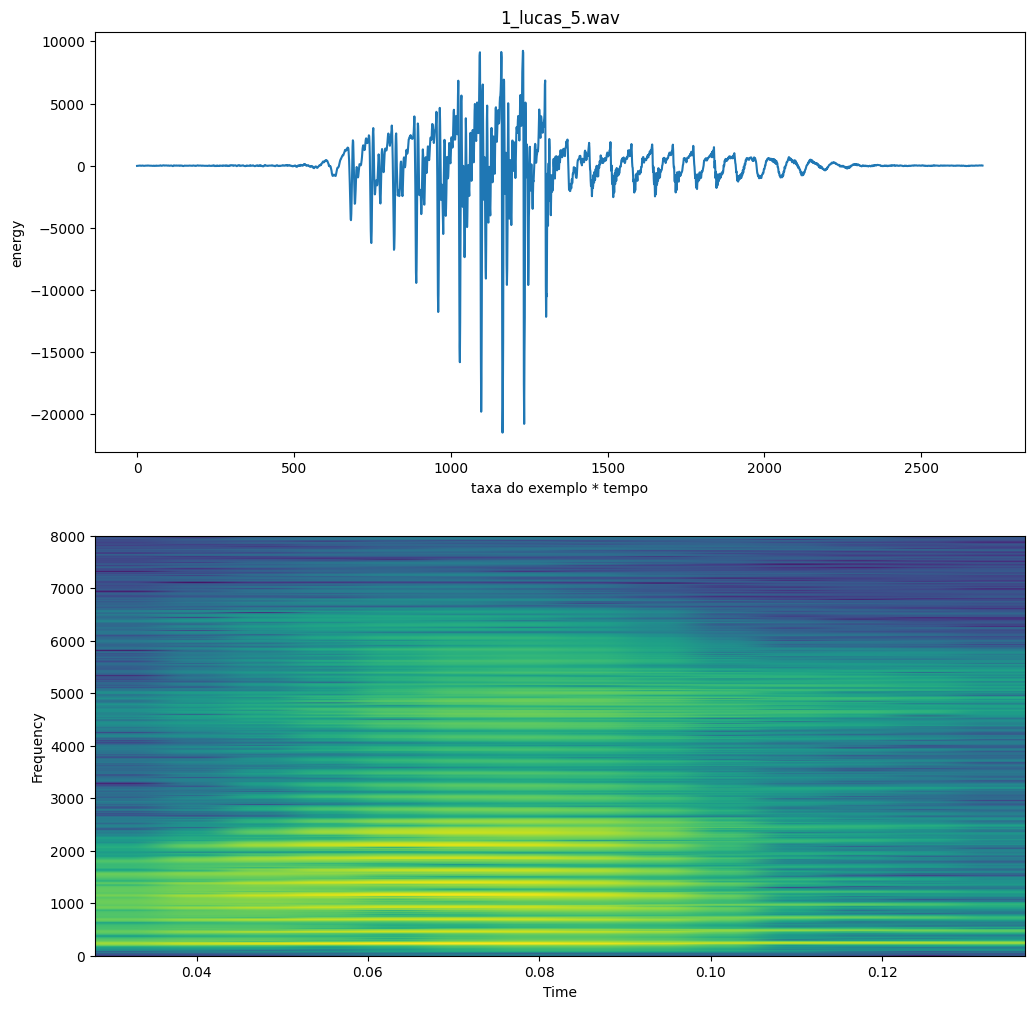

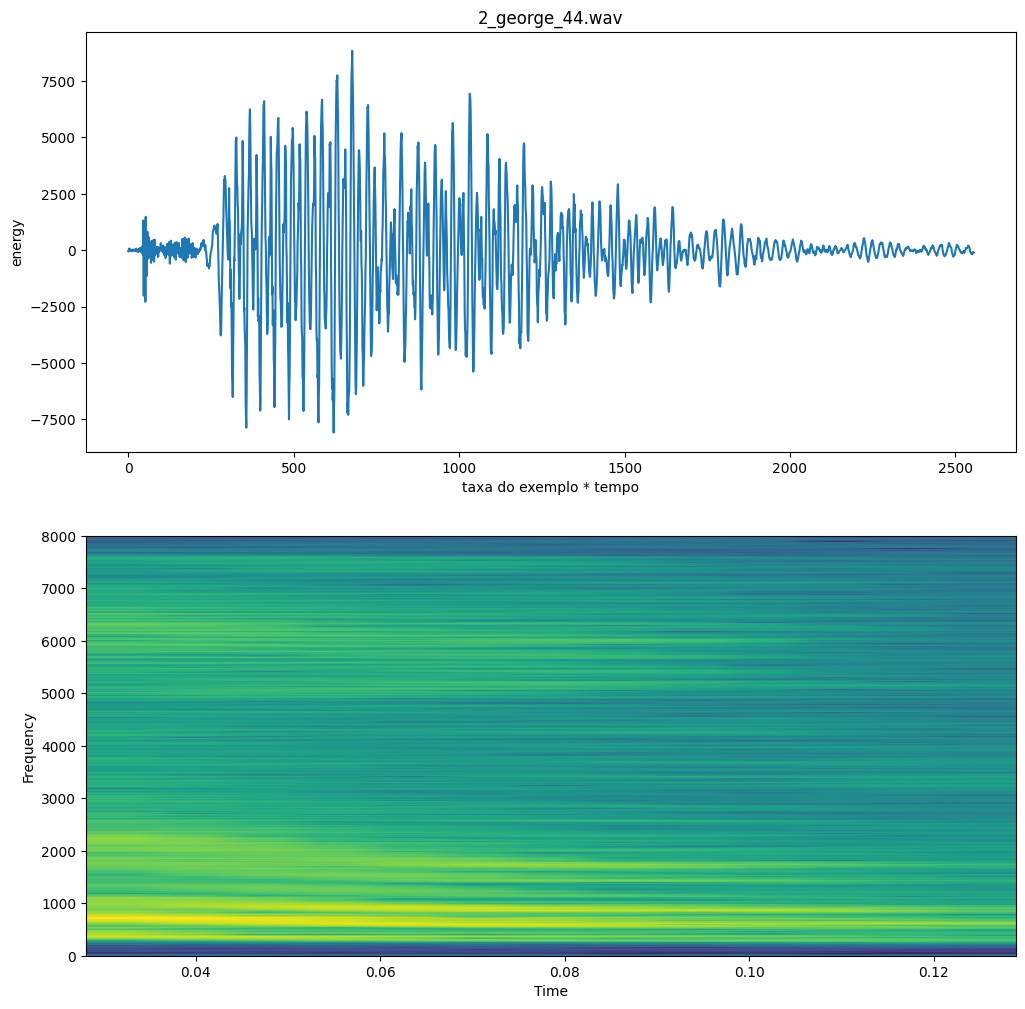

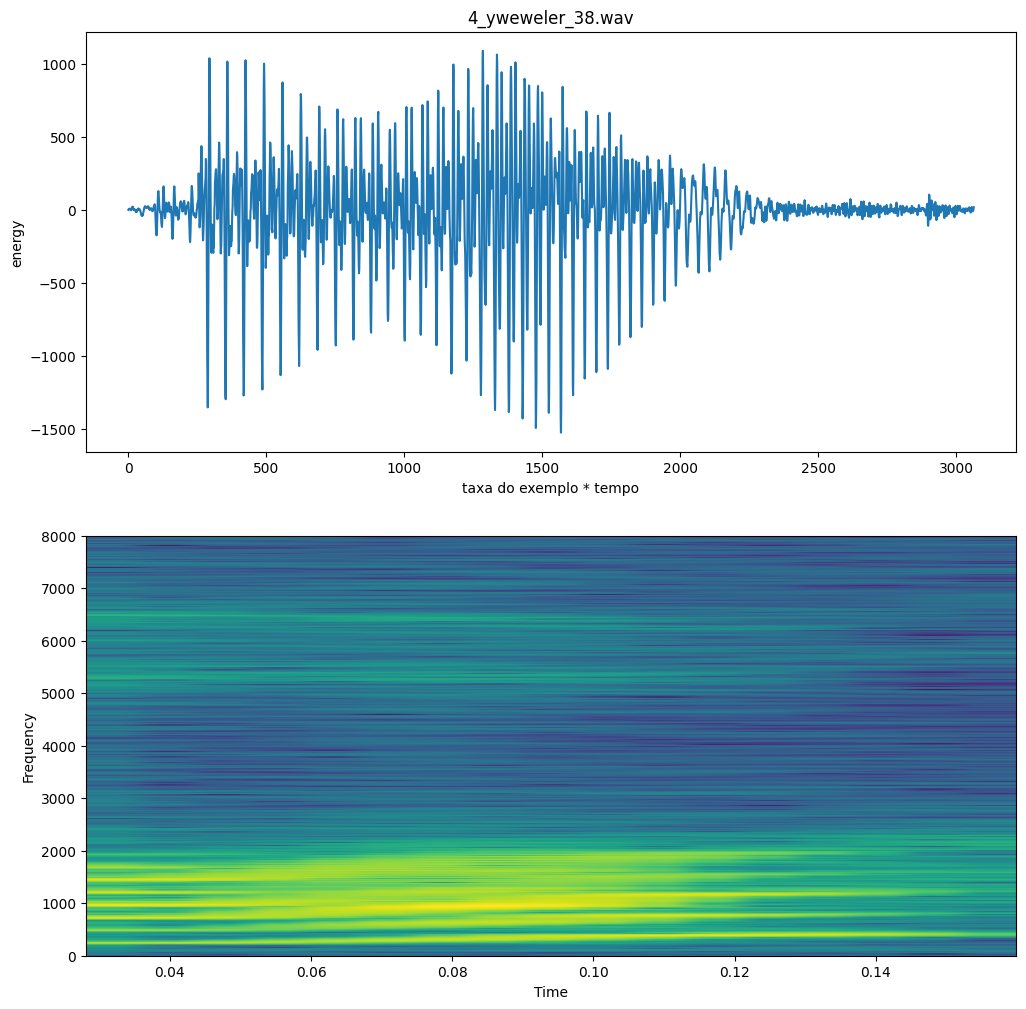

In [3]:
for i in range(5): 
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('taxa do exemplo * tempo')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [ ]:
# função de utilidade para obter informações de som e taxa de quadros
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# para todo audio, vamos fazer o espectrograma e salvar com a label que ele pertence
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# printar as 10 classes que tem no data
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
# nome dos arquivos para a classe 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

In [ ]:
# constantes
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# criando um dataset contendo o espectrograma de treino
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# criando um dataset contendo o espectrograma de validação
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)